The BigMart sales dataset is a popular dataset used in machine learning and regression tasks. It contains information about sales data of various products in different BigMart stores. The dataset is often used to predict the sales of products based on different features.

Here is a brief description of the attributes in the BigMart sales dataset:

1. Item_Identifier: Unique identifier for each product (categorical).
2. Item_Weight: Weight of the product (numeric).
3. Item_Fat_Content: Whether the product is low fat or regular (categorical).
4. Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product (numeric).
5. Item_Type: The category of the product (categorical).
6. Item_MRP: Maximum Retail Price (MRP) of the product (numeric).
7. Outlet_Identifier: Unique identifier for each store (categorical).
8. Outlet_Establishment_Year: The year in which the store was established (numeric).
9. Outlet_Size: The size of the store (categorical).
10. Outlet_Location_Type: The type of location where the store is situated (categorical).
11. Outlet_Type: The type of outlet (categorical).
12. Item_Outlet_Sales: The sales of the product in the particular store (numeric).

The challenge in working with the BigMart sales dataset is to build a regression model that accurately predicts the sales of products based on the given features. This can be a challenging task due to the presence of missing values, categorical variables, and the need to handle outliers and skewed distributions. Additionally, feature engineering techniques may be required to extract meaningful information from the given attributes and improve the model's performance.


# import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

#load the dataset

In [ ]:
"""
!gdown --id 1l_pRxlRHqe9NY64-PiB6KFGmNlPwDgfR
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c 'BigMart-Sales-Data'

"""

403 - Forbidden - Permission 'competitions.participate' was denied


In [ ]:
!gdown --id 1VZ2oDw9h7yUiBuCblJQvpA2kcmt5X1I_
data = pd.read_csv('/content/Train.csv')

In [55]:
data.sample(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1285,FDY56,NaN,Regular,0.062109,Fruits and Vegetables,223.7062,OUT027,1985,Medium,Tier 3,Supermarket Type3,4965.5364
1549,FDX27,20.70,reg,0.114295,Dairy,94.9436,OUT049,1999,Medium,Tier 1,Supermarket Type1,1229.0668
2241,FDY11,6.71,Regular,0.029560,Baking Goods,65.8142,OUT046,1997,Small,Tier 1,Supermarket Type1,856.8846
4068,DRE27,11.85,Low Fat,0.132940,Dairy,98.0726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1761.7068
1392,FDY20,12.50,Regular,0.082086,Fruits and Vegetables,92.2488,OUT018,2009,Medium,Tier 3,Supermarket Type2,1358.2320


#EDA

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [57]:
data.shape

(8523, 12)

In [ ]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

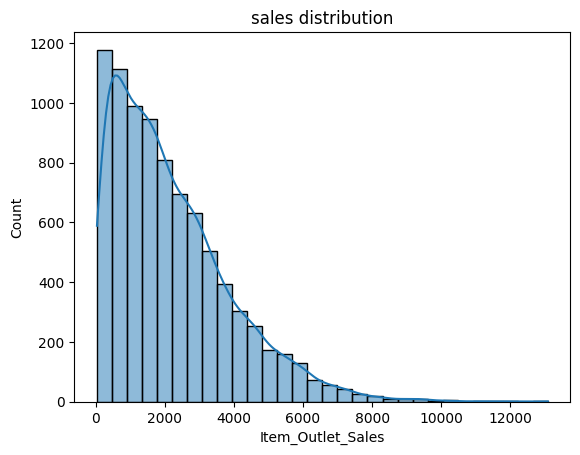

In [ ]:
sns.histplot(data['Item_Outlet_Sales'], kde=True, bins=30)
plt.title('sales distribution')
plt.show()

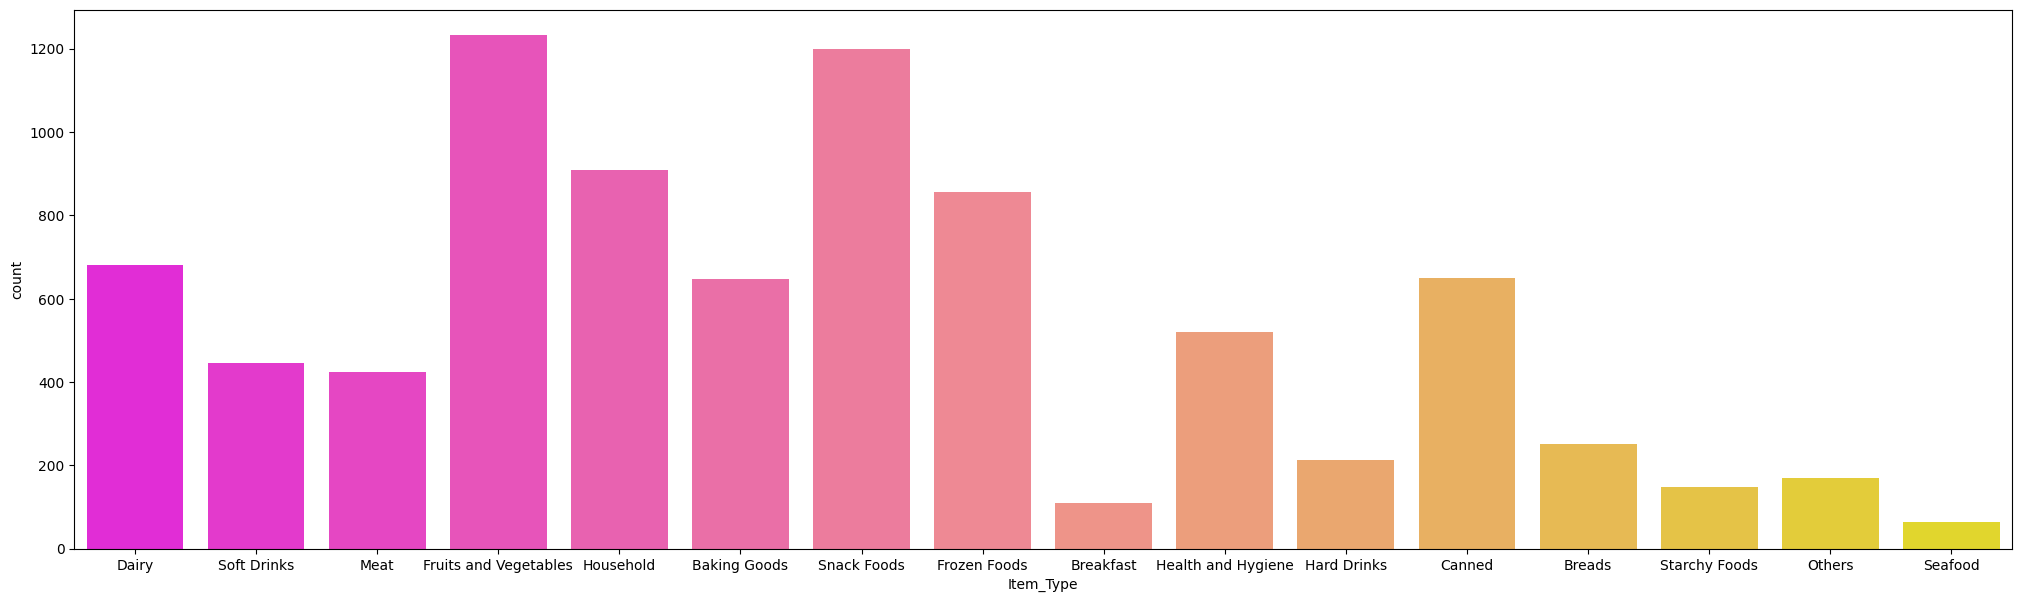

In [59]:
plt.figure(figsize=(25,7))
sns.countplot(x=data['Item_Type'],palette='spring')
plt.show()

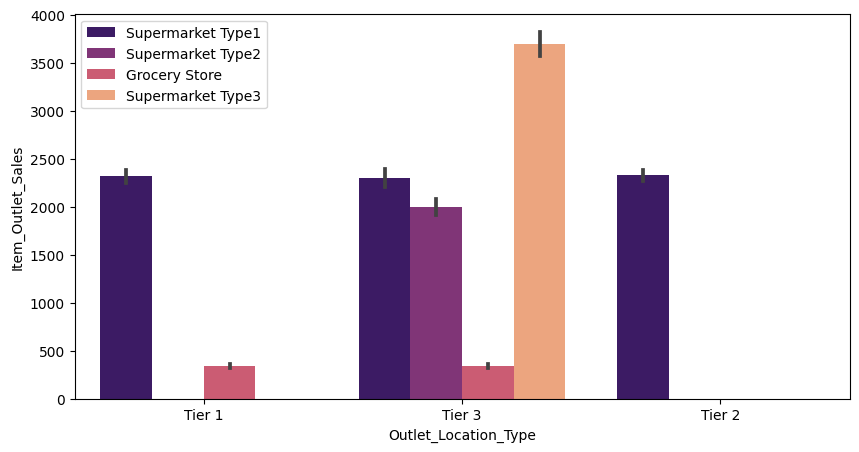

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=data['Outlet_Location_Type'],y=data['Item_Outlet_Sales'],hue=data['Outlet_Type'],palette='magma')
plt.legend()
plt.show()

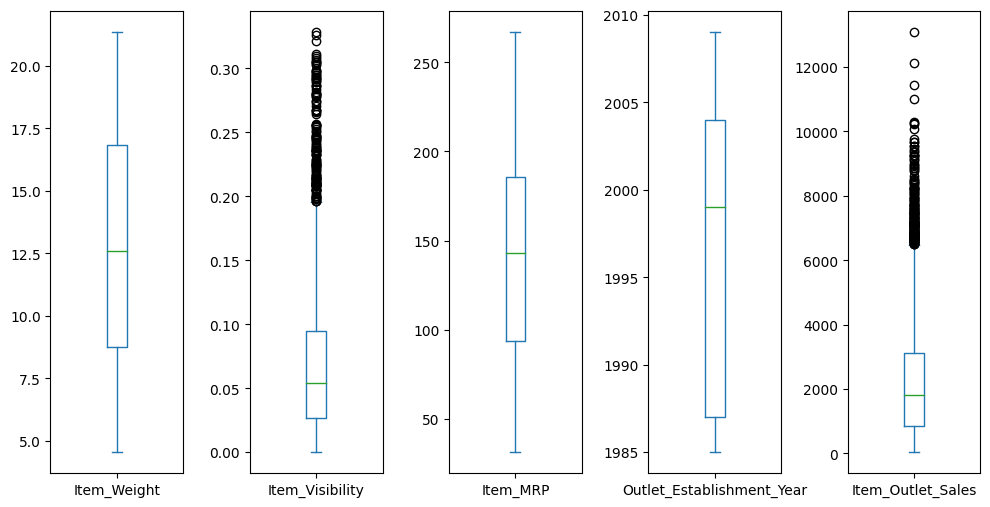

In [188]:
data.select_dtypes('number').plot(kind='box', subplots=True,sharey=False,figsize=(12,6))
plt.subplots_adjust(wspace=0.5);

In [189]:
df=data[['Item_Outlet_Sales','Item_Visibility']]
for k, v in df.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  iqr = q3 - q1
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(data)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column Item_Outlet_Sales outliers = 2.18%
Column Item_Visibility outliers = 1.69%


#data preprocessing

Handle Outliers in: Item Visibility and Outlet Sales


`handle_outliers_iqr` function handles outliers using the IQR (Interquartile Range) method.In this method we replace outlier values with NaN and then forward fill NaN values with the previous non-outlier value.

In [205]:
"""
upper1 = data['Item_Visibility'].quantile(0.95)
data = data[~(data['Item_Visibility'] > upper1)]
upper2 = data['Item_Outlet_Sales'].quantile(0.95)
data = data[~(data['Item_Outlet_Sales'] > upper2)]
"""

In [203]:
def handle_outliers_iqr(df, factor=1.5):

  for k, v in df.items():
    Q1 = v.quantile(0.25)
    Q3 = v.quantile(0.75)
    IQR = Q3 - Q1
    v[(v < (Q1 - factor * IQR)) | (v > (Q3 + factor * IQR))] = np.nan
  df.fillna(method='ffill', inplace=True)

handle_outliers_iqr(data[['Item_Outlet_Sales','Item_Visibility']])


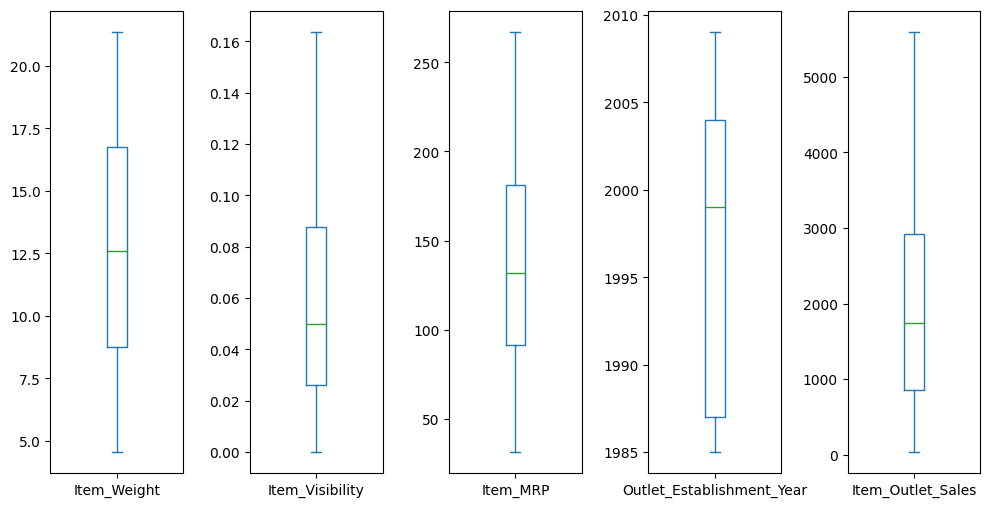

In [206]:
data.plot(kind='box', subplots=True,sharey=False,figsize=(12,6))
plt.subplots_adjust(wspace=0.5);

In [208]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1147
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2182
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [209]:
data['Outlet_Size'].fillna(data['Outlet_Size'].mode()[0], inplace=True)
data['Item_Weight'].fillna(value=np.mean(data['Item_Weight']), inplace=True)

In [210]:
data.duplicated().sum()

0

In [211]:
data['Item_Fat_Content'].unique()
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'Low Fat': 0,'low fat': 0,'LF': 0, 'reg': 1, 'Regular': 1})

data['Outlet_Size'].unique()
data['Outlet_Size'] = data['Outlet_Size'].replace({'Small': 0,'Medium': 1,'High': 2})

data['Outlet_Location_Type'].unique()
data['Outlet_Location_Type'] = data['Outlet_Location_Type'].replace({'Tier 3': 0,'Tier 2': 1,'Tier 1': 2})

data['Outlet_Type'].unique()
data['Outlet_Type'] = data['Outlet_Type'].replace({'Grocery Store': 0,'Supermarket Type1': 1,'Supermarket Type2': 2,'Supermarket Type3': 3})

le = LabelEncoder()
data['Item_Type'] = le.fit_transform(data['Item_Type'])

#data = pd.get_dummies(data, columns=['Item_Type'])

In [92]:
data.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content               int64
Item_Visibility              float64
Item_Type                      int64
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                    int64
Outlet_Location_Type           int64
Outlet_Type                    int64
Item_Outlet_Sales            float64
dtype: object

In [111]:
data.describe()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.352693,0.066132,7.226681,140.992782,1997.831867,0.829168,0.887129,1.201220,2181.288914
std,4.226124,0.477836,0.051598,4.209990,62.275067,8.371760,0.600327,0.812757,0.796459,1706.499616
min,4.555000,0.000000,0.000000,0.000000,31.290000,1985.000000,0.000000,0.000000,0.000000,33.290000
25%,9.310000,0.000000,0.026989,4.000000,93.826500,1987.000000,0.000000,0.000000,1.000000,834.247400
50%,12.857645,0.000000,0.053931,6.000000,143.012800,1999.000000,1.000000,1.000000,1.000000,1794.331000
75%,16.000000,1.000000,0.094585,10.000000,185.643700,2004.000000,1.000000,2.000000,1.000000,3101.296400
max,21.350000,1.000000,0.328391,15.000000,266.888400,2009.000000,2.000000,2.000000,3.000000,13086.964800


#feature engineering

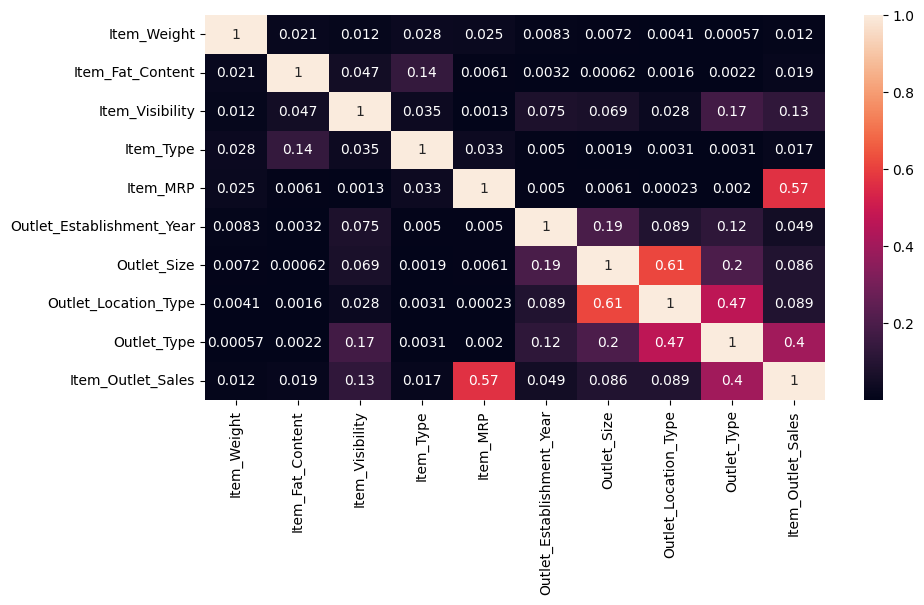

In [112]:
plt.figure(figsize=(10, 5))
sns.heatmap(data.corr().abs(),  annot=True);

From correlation matrix, we see Outlet_Size and Outlet_Location_Type are highly correlated features. The columns Outlet_Type, Item_MRP has a correlation score about 0.5 with MEDV which is a good indication of using as predictors.

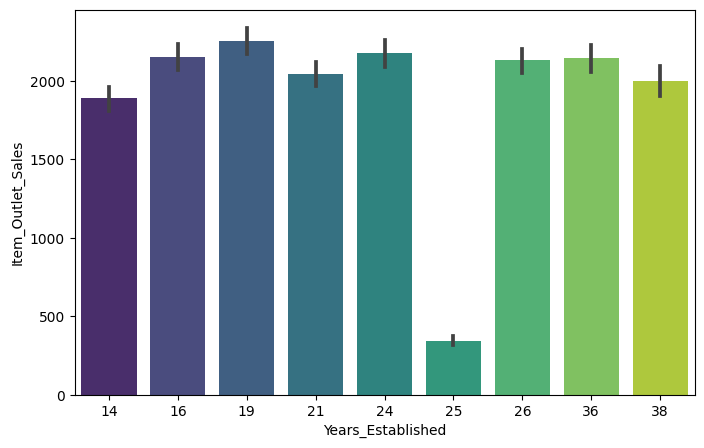

In [212]:
data['Years_Established'] = data['Outlet_Establishment_Year'].apply(lambda x: 2023 - x)
plt.figure(figsize=(8,5))
sns.barplot(x=data['Years_Established'],y=data['Item_Outlet_Sales'],palette='viridis')
plt.show()

There are some columns that needs to be dropped as they don't seem helping our analysis.

In [213]:
data = data.drop(['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year'],axis=1)

In [214]:
data.shape

(7691, 10)

In [116]:
data.head(2)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years_Established
0,9.30,0,0.016047,4,249.8092,1,2,1,3735.1380,24
1,5.92,1,0.019278,14,48.2692,1,0,2,443.4228,14


#Transforming Skewed Features

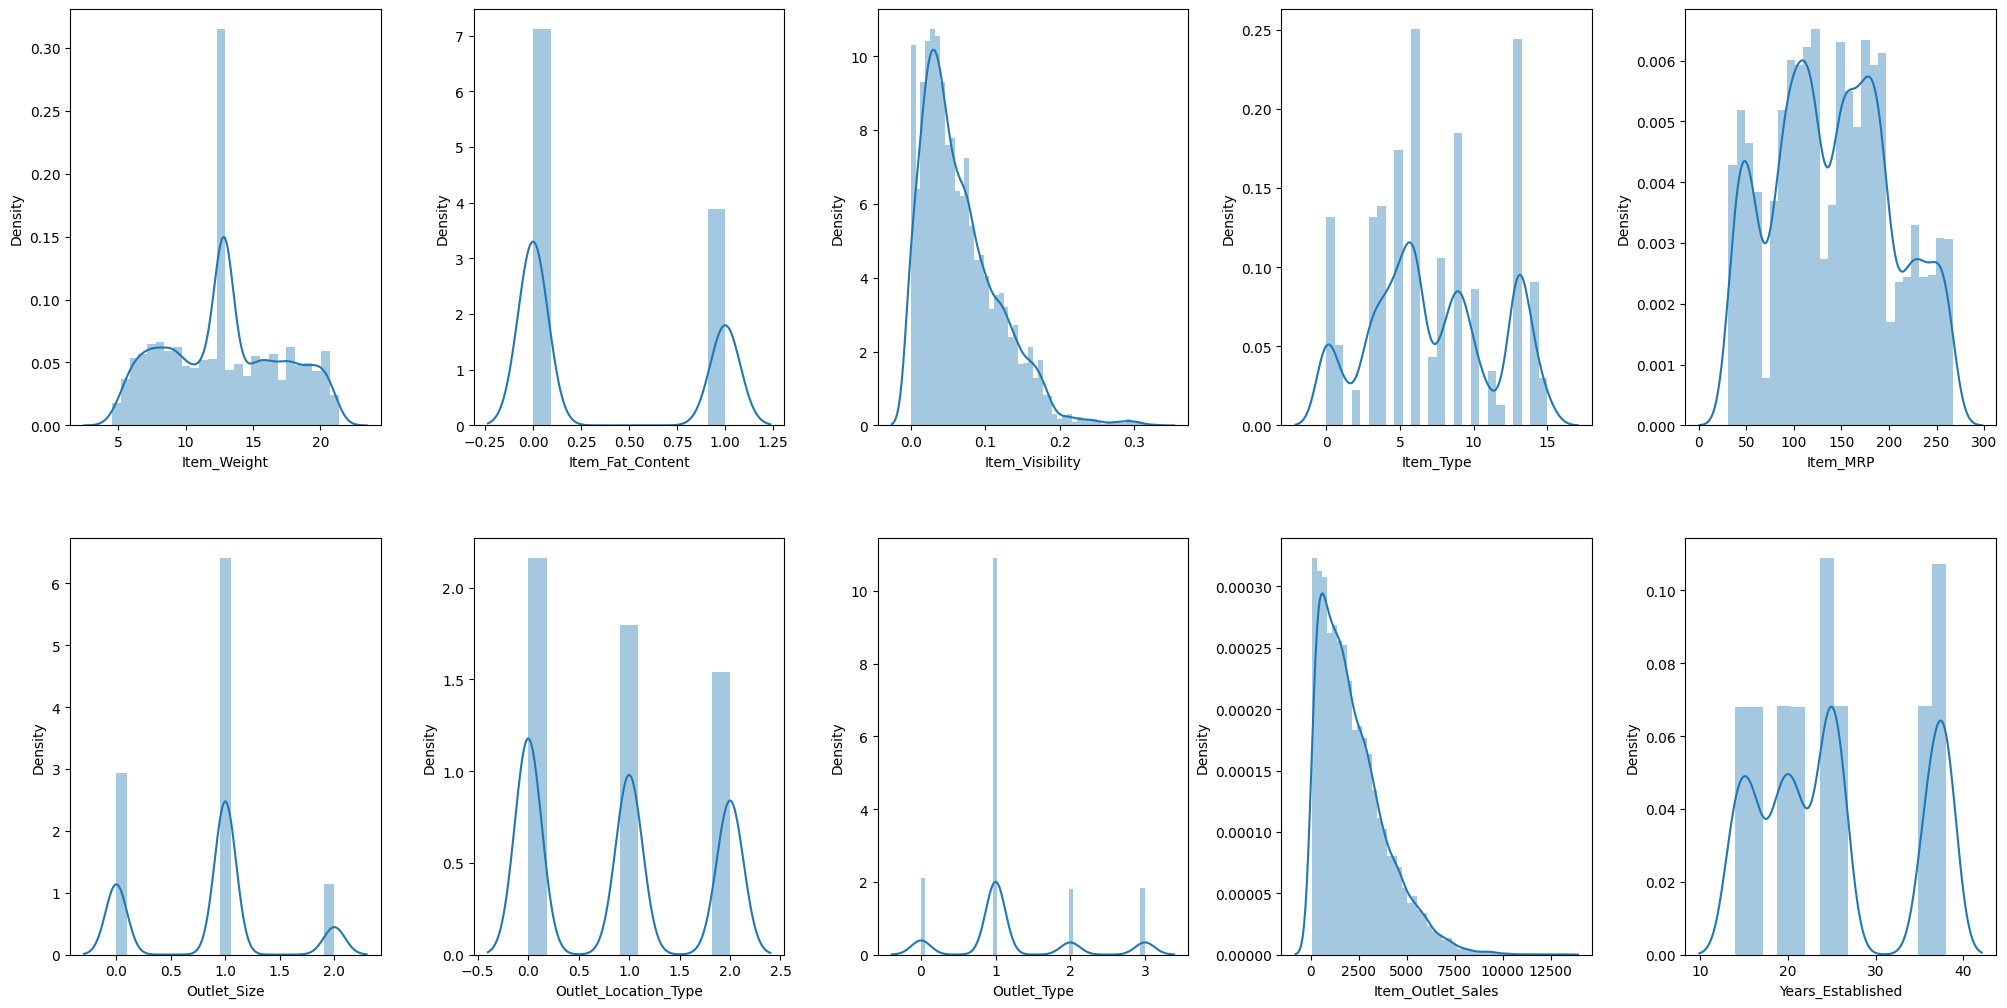

In [117]:
import warnings
warnings.filterwarnings("ignore")
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()

for k,v in data.items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [118]:
data[data.columns].skew().sort_values(ascending=False)

Item_Outlet_Sales       1.177531
Item_Visibility         1.167091
Outlet_Type             0.927438
Item_Fat_Content        0.616705
Years_Established       0.396641
Outlet_Location_Type    0.209093
Item_MRP                0.127202
Item_Type               0.101655
Item_Weight             0.090561
Outlet_Size             0.087072
dtype: float64

We use log transform to hanlde skewed data

In [215]:
for col in data.columns:
    if np.abs(data[col].skew()) > 0.1:
        data[col] = np.log1p(data[col])


In [120]:
data[data.columns].skew().sort_values(ascending=False)

Item_Visibility         1.015334
Item_Fat_Content        0.616705
Item_Weight             0.090561
Outlet_Size             0.087072
Years_Established       0.039228
Outlet_Location_Type   -0.086435
Outlet_Type            -0.236040
Item_MRP               -0.726014
Item_Outlet_Sales      -0.882266
Item_Type              -1.300896
dtype: float64

#splitting data to train and test


In [216]:
X = data.drop(['Item_Outlet_Sales'], axis=1)
y = data['Item_Outlet_Sales']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

#Scalling

In [218]:
MMS = MinMaxScaler()
X_train = MMS.fit_transform(X_train)
X_test = MMS.transform(X_test)

#Model Training

In [219]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)

#Predict and Evaluate the model

In [220]:
mse = mean_squared_error(y_test,y_pred)
print("mean squared error:",mse)
from math import sqrt
rmse = sqrt(mse)
print("Root Mean Squared Error:",rmse)
r_sq = r2_score(y_test, y_pred)
print("r2_score:",r_sq)

mean squared error: 0.3224320276041777
Root Mean Squared Error: 0.567830985068777
r2_score: 0.643047176284397


#Feature Importance

To select the most effective features for linear regression, we can use a linear regression model and assess the importance of each feature based on their coefficients. Features with larger coefficients are considered more important.

`Outlet_Size`,`Outlet_Location_Type`,`Outlet_Type`,`Item_MRP`

In [171]:
w0_LR = linreg.intercept_
w_LR = linreg.coef_
print("Estimated coefficients by Linear Regression:\nw_0 = {}  \
      \nw = {}".format(w0_LR, w_LR))

Estimated coefficients by Linear Regression:
w_0 = 4.00162481648515        
w = [-0.03509244  0.01612674 -0.22338573 -0.00253386  2.18698695  0.67660661
  0.81309524  2.51862604 -0.07478304]


#Plot the learning curve

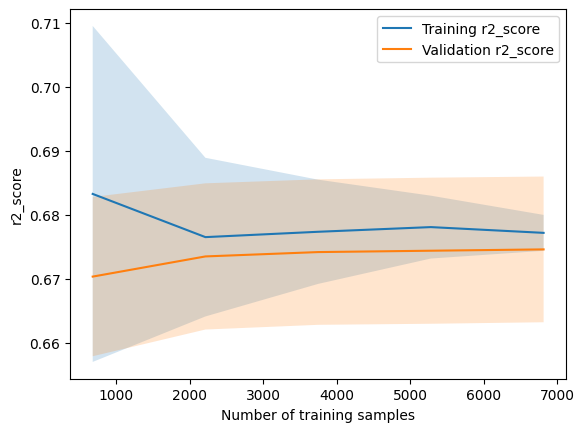

In [185]:
train_sizes, train_scores, test_scores = learning_curve(
    linreg, X, y, cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0), scoring='r2', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, label='Training r2_score')
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Validation r2_score')
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.2)
plt.xlabel('Number of training samples')
plt.ylabel('r2_score')
plt.legend(loc='best')
plt.show()

#Hyperparameters tuning

In [173]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('regressor', LinearRegression())])
hyp_pars = {'regressor': [Ridge(), Lasso()],'regressor__alpha': [1e-4, 1e-3, 1e-2, 0.1]}
randomsearch = RandomizedSearchCV(pipeline, hyp_pars, cv=10)
randomsearch.fit(X,y)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('regressor',
                                              LinearRegression())]),
                   param_distributions={'regressor': [Ridge(alpha=0.1),
                                                      Lasso()],
                                        'regressor__alpha': [0.0001, 0.001,
                                                             0.01, 0.1]})

In [174]:
best_model = randomsearch.best_estimator_
best_parameters = randomsearch.best_params_
print(best_parameters)
print(randomsearch.best_score_)

{'regressor__alpha': 0.1, 'regressor': Ridge(alpha=0.1)}
0.6751631033415647
